<a href="https://colab.research.google.com/github/Dslover3544/ML-Password-Strength-Project/blob/main/Phishing_URL_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# run this cell first
!pip install -q scikit-learn pandas numpy matplotlib seaborn

import random, string, math
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [4]:
# ---------------------------
# helper functions
# ---------------------------
common_passwords = [
    "123456","password","qwerty","abc123","iloveyou","admin","welcome",
    "login","passw0rd","letmein"
]

def random_username(min_len=5, max_len=10):
    return ''.join(random.choices(string.ascii_lowercase, k=random.randint(min_len,max_len)))

def make_password(kind='benign'):
    # kind = 'benign', 'weak', 'complex'
    if kind == 'weak':
        return random.choice(common_passwords)
    if kind == 'complex':
        parts = []
        parts.append(''.join(random.choices(string.ascii_lowercase, k=random.randint(5,8))))
        parts.append(''.join(random.choices(string.digits, k=random.randint(2,4))))
        parts.append(''.join(random.choices(string.punctuation, k=random.randint(1,3))))
        return ''.join(parts)
    # default benign-ish
    s = ''.join(random.choices(string.ascii_lowercase + string.digits, k=random.randint(6,12)))
    return s

def shannon_entropy(s):
    if len(s) == 0:
        return 0.0
    counts = Counter(s)
    probs = [c/len(s) for c in counts.values()]
    return -sum(p*math.log2(p) for p in probs)

# ---------------------------
# create samples
# ---------------------------
rows = []
N = 10000
for _ in range(N):
    # randomly choose scenario
    scenario = random.choices(
        population=['benign','weak','complex','suspicious-ip'],
        weights=[0.65, 0.18, 0.12, 0.05],
        k=1
    )[0]

    username = random_username()
    if scenario == 'benign':
        pwd = make_password('complex') if random.random() < 0.6 else make_password('benign')
        failed = random.choices([0,1,2], weights=[0.8,0.15,0.05])[0]
        ip_risk = round(random.random()*0.3,3)  # low risk
    elif scenario == 'weak':
        pwd = make_password('weak')
        failed = random.choices([0,1,2,3], weights=[0.4,0.3,0.2,0.1])[0]
        ip_risk = round(random.random()*0.5,3)
    elif scenario == 'complex':
        pwd = make_password('complex')
        failed = random.choices([0,1], weights=[0.9,0.1])[0]
        ip_risk = round(random.random()*0.2,3)
    else:  # suspicious-ip (e.g., many fails + high ip risk)
        pwd = make_password(random.choice(['weak','benign']))
        failed = random.choices([3,4,5,6,7], weights=[0.2,0.25,0.25,0.2,0.1])[0]
        ip_risk = round(random.uniform(0.6,1.0),3)

    hour = random.randint(0,23)
    # label rules (this is synthetic — ML will learn patterns)
    label = 1 if (pwd in common_passwords or failed >= 3 or ip_risk > 0.6) else 0

    rows.append({
        'username': username,
        'password': pwd,
        'failed_attempts': failed,
        'hour': hour,
        'ip_risk': ip_risk,
        'label': label
    })

df = pd.DataFrame(rows)
# save
df.to_csv('login_dataset.csv', index=False)
print("Saved login_dataset.csv with", len(df), "rows")
df.head(8)


Saved login_dataset.csv with 10000 rows


,username,password,failed_attempts,hour,ip_risk,label
0,jmsocas,xxxirn33:,0,17,0.174,0
1,hmkfitj,wvdgmnq969@,0,17,0.144,0
2,cxtqcpsds,taznwisd931;!,0,5,0.007,0
3,yxadka,password,4,6,0.952,1
4,kmlnid,pnnbr1bt9y,0,15,0.008,0
5,ctxtqrhov,lghpf132/%\,0,11,0.095,0
6,fvswluds,kpykjjik98!}`,1,1,0.270,0
7,xbdrwuxhzv,bygsyo25|!,0,19,0.171,0


In [5]:
def extract_features(df):
    df2 = df.copy()
    df2['pwd_len'] = df2['password'].str.len()
    df2['has_digit'] = df2['password'].str.contains(r'\d').astype(int)
    df2['has_special'] = df2['password'].str.contains(r'[^A-Za-z0-9]').astype(int)
    df2['has_upper'] = df2['password'].str.contains(r'[A-Z]').astype(int)
    df2['unique_chars'] = df2['password'].apply(lambda s: len(set(s)))
    df2['entropy'] = df2['password'].apply(shannon_entropy)
    # keep useful columns
    feature_cols = ['pwd_len','has_digit','has_special','has_upper','unique_chars','entropy',
                    'failed_attempts','hour','ip_risk']
    return df2, feature_cols

df_feat, feature_cols = extract_features(df)
df_feat.head(6)


,username,password,failed_attempts,hour,ip_risk,label,pwd_len,has_digit,has_special,has_upper,unique_chars,entropy
0,jmsocas,xxxirn33:,0,17,0.174,0,9,1,1,0,6,2.419382
1,hmkfitj,wvdgmnq969@,0,17,0.144,0,11,1,1,0,10,3.277613
2,cxtqcpsds,taznwisd931;!,0,5,0.007,0,13,1,1,0,13,3.700440
3,yxadka,password,4,6,0.952,1,8,0,0,0,7,2.750000
4,kmlnid,pnnbr1bt9y,0,15,0.008,0,10,1,0,0,8,2.921928
5,ctxtqrhov,lghpf132/%\,0,11,0.095,0,11,1,1,0,11,3.459432


In [6]:
def extract_features(df):
    df2 = df.copy()
    df2['pwd_len'] = df2['password'].str.len()
    df2['has_digit'] = df2['password'].str.contains(r'\d').astype(int)
    df2['has_special'] = df2['password'].str.contains(r'[^A-Za-z0-9]').astype(int)
    df2['has_upper'] = df2['password'].str.contains(r'[A-Z]').astype(int)
    df2['unique_chars'] = df2['password'].apply(lambda s: len(set(s)))
    df2['entropy'] = df2['password'].apply(shannon_entropy)
    # keep useful columns
    feature_cols = ['pwd_len','has_digit','has_special','has_upper','unique_chars','entropy',
                    'failed_attempts','hour','ip_risk']
    return df2, feature_cols

df_feat, feature_cols = extract_features(df)
df_feat.head(6)


,username,password,failed_attempts,hour,ip_risk,label,pwd_len,has_digit,has_special,has_upper,unique_chars,entropy
0,jmsocas,xxxirn33:,0,17,0.174,0,9,1,1,0,6,2.419382
1,hmkfitj,wvdgmnq969@,0,17,0.144,0,11,1,1,0,10,3.277613
2,cxtqcpsds,taznwisd931;!,0,5,0.007,0,13,1,1,0,13,3.700440
3,yxadka,password,4,6,0.952,1,8,0,0,0,7,2.750000
4,kmlnid,pnnbr1bt9y,0,15,0.008,0,10,1,0,0,8,2.921928
5,ctxtqrhov,lghpf132/%\,0,11,0.095,0,11,1,1,0,11,3.459432


Label counts:
 label
0    7698
1    2302
Name: count, dtype: int64


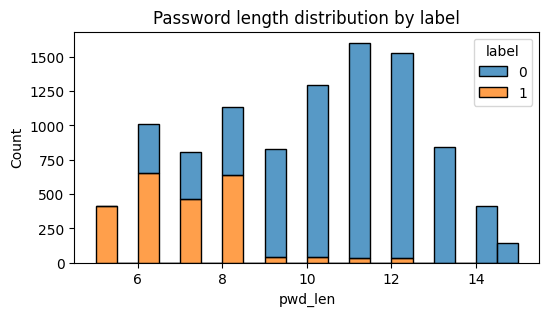

In [7]:
# class balance
print("Label counts:\n", df_feat['label'].value_counts(normalize=False))

# some simple plots (optional)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,3))
sns.histplot(df_feat, x='pwd_len', hue='label', bins=20, stat='count', multiple='stack')
plt.title('Password length distribution by label')
plt.show()


Label counts:
 label
0    7698
1    2302
Name: count, dtype: int64


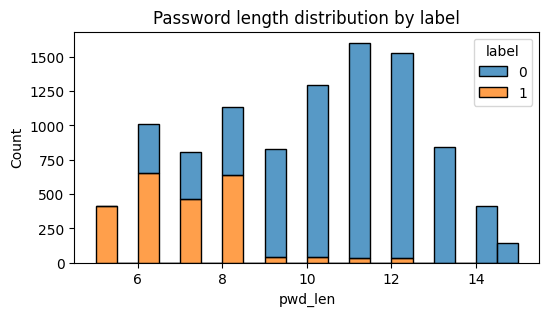

In [8]:
# class balance
print("Label counts:\n", df_feat['label'].value_counts(normalize=False))

# some simple plots (optional)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,3))
sns.histplot(df_feat, x='pwd_len', hue='label', bins=20, stat='count', multiple='stack')
plt.title('Password length distribution by label')
plt.show()


In [9]:
X = df_feat[feature_cols]
y = df_feat['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [10]:
# --- Logistic Regression ---
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
print("LogReg acc:", accuracy_score(y_test, pred_lr))
print(classification_report(y_test, pred_lr))

# --- Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print("RandomForest acc:", accuracy_score(y_test, pred_rf))
print(classification_report(y_test, pred_rf))


LogReg acc: 0.959
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1540
           1       0.93      0.89      0.91       460

    accuracy                           0.96      2000
   macro avg       0.95      0.94      0.94      2000
weighted avg       0.96      0.96      0.96      2000

RandomForest acc: 0.972
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1540
           1       0.94      0.93      0.94       460

    accuracy                           0.97      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.97      0.97      0.97      2000



In [11]:
def prepare_one(password, failed_attempts, hour, ip_risk):
    s = pd.DataFrame([{
        'password': password,
        'failed_attempts': failed_attempts,
        'hour': hour,
        'ip_risk': ip_risk
    }])
    s2, _ = extract_features(s)
    return s2[feature_cols]

def predict_attempt(model, password, failed_attempts=0, hour=12, ip_risk=0.1):
    Xp = prepare_one(password, failed_attempts, hour, ip_risk)
    p = model.predict(Xp)[0]
    proba = model.predict_proba(Xp)[0][1] if hasattr(model, "predict_proba") else None
    return {"label": int(p), "suspicious_prob": float(proba) if proba is not None else None}

# try it:
print(predict_attempt(rf, "123456", failed_attempts=0, hour=3, ip_risk=0.05))
print(predict_attempt(rf, "S3cur3!pass", failed_attempts=0, hour=15, ip_risk=0.02))
print(predict_attempt(rf, "letmein", failed_attempts=5, hour=2, ip_risk=0.9))


{'label': 0, 'suspicious_prob': 0.33}
{'label': 0, 'suspicious_prob': 0.0}
{'label': 1, 'suspicious_prob': 1.0}


In [12]:
import joblib
joblib.dump(rf, 'rf_suspicious_detector.joblib')


['rf_suspicious_detector.joblib']